<a href="https://colab.research.google.com/github/GersonHMG/2Dspace_ship_ai/blob/master/SysmicNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga de datos

En esta seccion se carga los datos y se visualizan

In [ ]:
def robot_filter(robot_id, team, df):
    robot_data = df[(df['RobotID'] == robot_id) & (df['Team'] == team)]
    robot_data = robot_data[["ElapsedTime", "Pos_X","Pos_Y","Orientation", "Vx_Command","Vy_Command","Vx_Actual","Vy_Actual","Angular_Command"]]
    robot_data = robot_data.rename(columns={'Pos_X': 'x',
                                            'Pos_Y':'y',
                                            'Orientation':'orientation',
                                            'Vx_Actual':'vx',
                                            'Vy_Actual':'vy',
                                            'Angular_Command':'angular_command',
                                            "Vx_Command":"vx_command",
                                            "Vy_Command":"vy_command"})
    return robot_data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_named_trajectories(filenames, rows, cols, robot_id=0, team=0):
    """
    Visualiza múltiples trayectorias desde archivos CSV arbitrarios en una cuadrícula de subplots.

    Parameters:
        filenames (list of str): Lista de nombres de archivos CSV (ej: ["train_data0.csv", "test_data.csv"])
        rows (int): Número de filas de subplots
        cols (int): Número de columnas de subplots
        robot_id (int): ID del robot a filtrar (por defecto 0)
        team (int): ID del equipo a filtrar (por defecto 0)
    """
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for ax, fname in zip(axes, filenames):
        try:
            df = pd.read_csv(fname)
            df = robot_filter(robot_id, team, df)
        except Exception as e:
            ax.set_title(f"Error: {fname}")
            ax.axis('off')
            continue

        ax.plot(df['x'], df['y'], marker='o', linewidth=1, markersize=2)
        ax.set_title(f"Trajectory from {fname}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.axis('equal')
        ax.grid(True)

    # Oculta subplots vacíos si hay más espacios que archivos
    for j in range(len(filenames), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

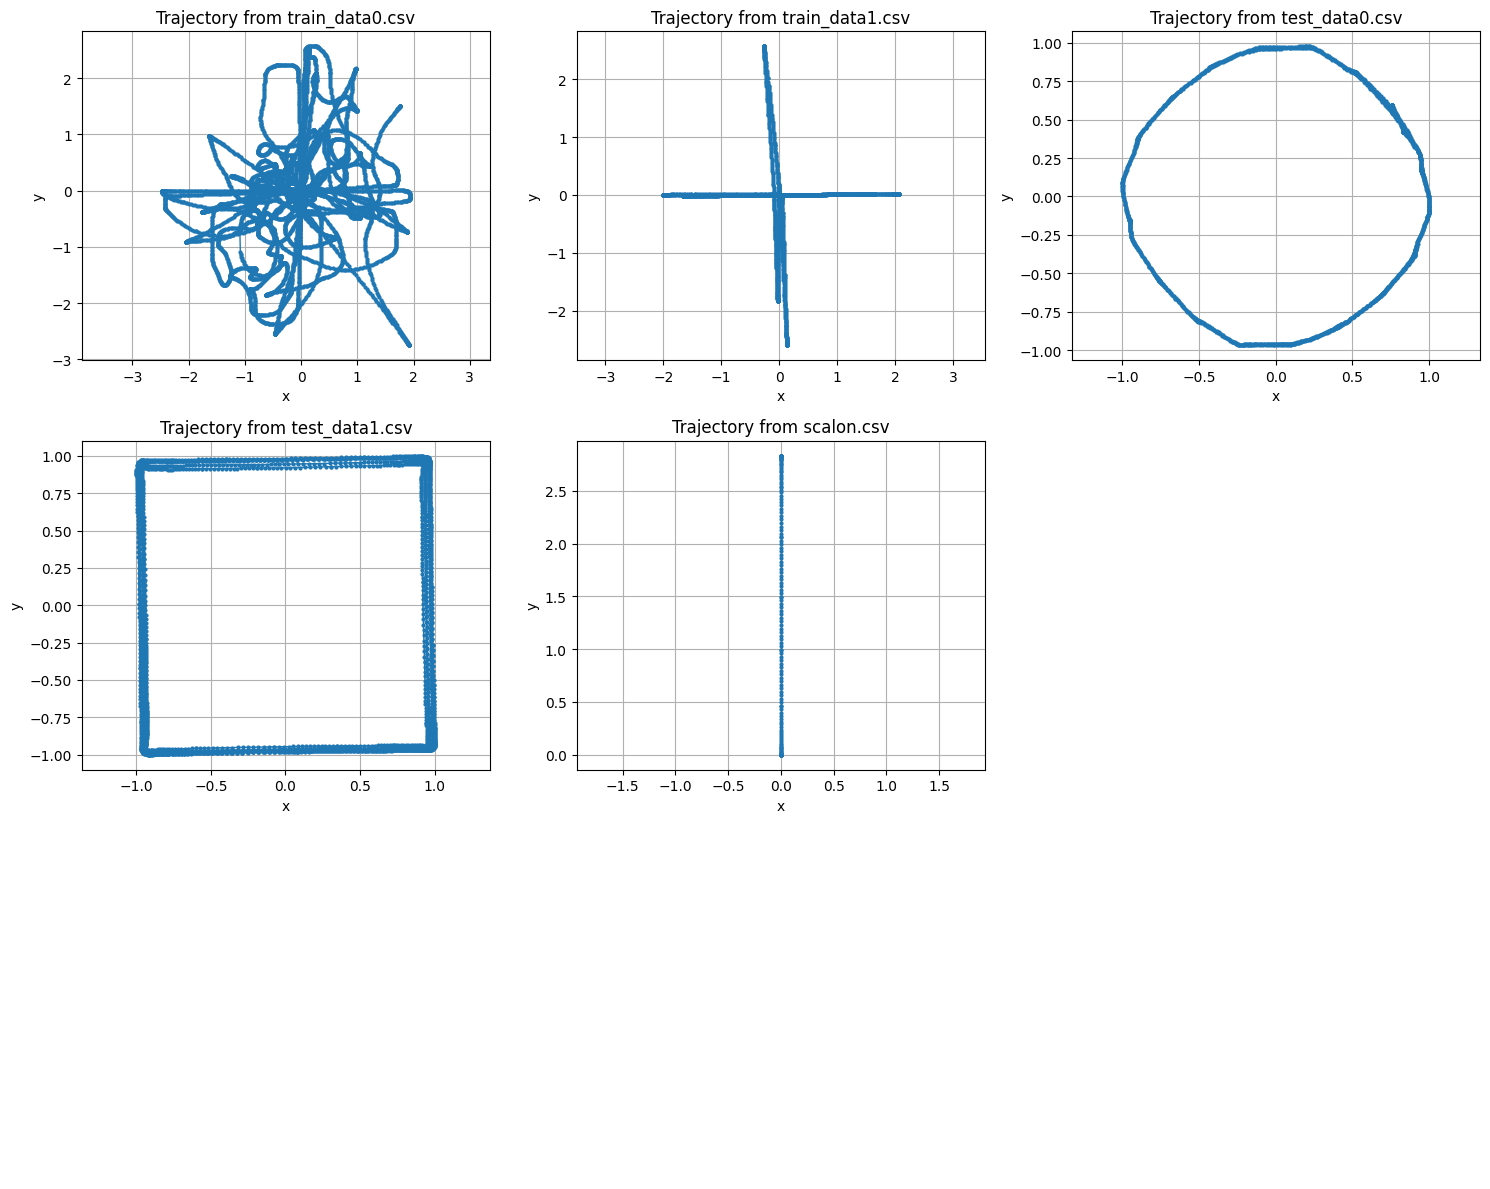

In [ ]:
plot_named_trajectories(
    filenames=["train_data0.csv", "train_data1.csv", "test_data0.csv", "test_data1.csv", "scalon.csv"],
    rows=3,
    cols=3
)

In [ ]:
import pandas as pd

# List of CSV filenames
filenames = ["train_data0.csv", "train_data1.csv"]

# Load and concatenate
df = pd.concat([pd.read_csv(fname) for fname in filenames], ignore_index=True)
df = robot_filter(0, 0, df).reset_index()

# Preprocesamiento

## Suavizado y adicion de features (velocidades)

Para el preprocesamiento de datos se utilizara el filtro de kalman extendido, un filtro bastante comun en lo que es la Robocup SSL. Unas de los pros de este filtro esque se permite generar las velocidades a partir de las posiciones. En este caso los hyperparametros del filtro se eligieron manualmente, buscando los parametros que mejor se adaptaban a la curva y disminuian el ruido. Para una visualizacion de la importancia del filtro, se comparan los datos filtrados con los datos verdaderos (Solo los datos que se ocuparan), en el caso de las velocidades se comparan las velocidades generadas por el filtro y las generadas por el metodo de diferencias finitas.

In [ ]:
import numpy as np

class ExtendedKalmanFilter:
    def __init__(self, initial_state, initial_covariance, process_noise, measurement_noise):
        """
        Initializes the EKF with initial state and covariance.
        State: [x, y, sin(θ), cos(θ), vx, vy, ω]
        """
        self.x = initial_state
        self.P = initial_covariance
        self.Q = process_noise
        self.R = measurement_noise

    def f(self, x, dt):
        """
        Motion model with orientation represented by sin(θ), cos(θ).
        """
        sin_theta, cos_theta, vx, vy, omega = x[2], x[3], x[4], x[5], x[6]
        theta = np.arctan2(sin_theta, cos_theta)
        theta += omega * dt  # update orientation

        new_x = x.copy()
        new_x[0] += vx * dt
        new_x[1] += vy * dt
        new_x[2] = np.sin(theta)
        new_x[3] = np.cos(theta)
        # vx, vy, omega unchanged
        return new_x

    def h(self, x):
        """
        Measurement model: returns [x, y, θ] from [x, y, sin(θ), cos(θ), ...]
        """
        theta = np.arctan2(x[2], x[3])
        return np.array([x[0], x[1], theta])

    def jacobian_f(self, x, dt):
        """
        Jacobian of motion model f w.r.t. state x.
        Approximate linearized model.
        """
        F = np.eye(7)
        F[0, 4] = dt  # ∂x/∂vx
        F[1, 5] = dt  # ∂y/∂vy

        theta = np.arctan2(x[2], x[3])
        omega = x[6]
        theta_new = theta + omega * dt
        F[2, 6] = dt * np.cos(theta_new)  # ∂sin(θ)/∂ω
        F[3, 6] = -dt * np.sin(theta_new)  # ∂cos(θ)/∂ω

        return F

    def jacobian_h(self, x):
        """
        Jacobian of measurement model h w.r.t. state x.
        """
        H = np.zeros((3, 7))
        H[0, 0] = 1  # ∂x_meas/∂x
        H[1, 1] = 1  # ∂y_meas/∂y

        sin_theta = x[2]
        cos_theta = x[3]
        denom = sin_theta**2 + cos_theta**2
        H[2, 2] = cos_theta / denom  # ∂θ/∂sin(θ)
        H[2, 3] = -sin_theta / denom  # ∂θ/∂cos(θ)

        return H

    def predict(self, dt):
        """
        EKF prediction step.
        """
        F = self.jacobian_f(self.x, dt)
        self.x = self.f(self.x, dt)
        self.P = F @ self.P @ F.T + self.Q

    def update(self, z):
        """
        EKF update step with measurement z.
        """
        H = self.jacobian_h(self.x)
        y = z - self.h(self.x)
        y[2] = (y[2] + np.pi) % (2 * np.pi) - np.pi  # wrap θ error

        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(len(self.x)) - K @ H) @ self.P

    def get_state(self):
        return self.x

    def get_covariance(self):
        return self.P

In [ ]:
import numpy as np

def compute_velocity(position_series, dt=1/60):
    """
    Computes velocity using explicit finite differences from a position time series.

    Parameters:
        position_series (array-like): Smoothed position values (e.g., x or y)
        dt (float): Time step between samples (default 1/60 for 60Hz)

    Returns:
        velocity_series (np.ndarray): Estimated velocity
    """
    position_array = np.asarray(position_series)
    N = len(position_array)
    velocity = np.zeros(N)

    for i in range(N):
        if i == 0:
            # Forward difference for the first point
            velocity[i] = (position_array[i + 1] - position_array[i]) / dt
        elif i == N - 1:
            # Backward difference for the last point
            velocity[i] = (position_array[i] - position_array[i - 1]) / dt
        else:
            # Central difference for interior points
            velocity[i] = (position_array[i + 1] - position_array[i - 1]) / (2 * dt)

    return velocity


def compute_angular_velocity(orientation_series, dt=1/60):
    """
    Computes angular velocity using finite difference from an angle time series.
    Handles wraparound automatically via np.unwrap.

    Parameters:
        orientation_series (array-like): Smoothed angles (in radians)
        dt (float): Time step between samples (default 1/60 for 60Hz)

    Returns:
        angular_velocity_series (np.ndarray): Estimated angular velocity in rad/s
    """
    theta = np.unwrap(orientation_series)
    omega = np.gradient(theta, dt)
    return omega

In [ ]:
import numpy as np
import pandas as pd

def initialize_ekf(df):
    """Inicializa el estado, la covarianza y el EKF"""
    pos_x = df['x'].values
    pos_y = df['y'].values
    orientations = df['orientation'].values  # en radianes

    initial_state = np.array([
        pos_x[0],
        pos_y[0],
        np.sin(orientations[0]),
        np.cos(orientations[0]),
        0.0,  # vx
        0.0,  # vy
        0.0   # omega
    ])

    initial_cov = np.diag([1e-7] * 4 + [1.0, 1.0, 1.0])
    process_noise = np.diag([1e-7, 1e-7, 1e-4, 1e-4, 1e-4, 1e-4, 1e-2])
    measurement_noise = np.diag([1e-6, 1e-6, 1e-6])

    ekf = ExtendedKalmanFilter(initial_state, initial_cov, process_noise, measurement_noise)
    return ekf

def run_ekf_filter(df, ekf, dt=0.016):
    """Ejecuta el filtro de Kalman y retorna el DataFrame con las estimaciones"""
    pos_x = df['x'].values
    pos_y = df['y'].values
    orientations = df['orientation'].values

    est_tetha, est_vx, est_vy, est_omega = [], [], [], []
    est_x, est_y = [], []

    for i in range(len(df)):
        ekf.predict(dt)
        z = np.array([pos_x[i], pos_y[i], orientations[i]])
        ekf.update(z)

        state = ekf.get_state()
        est_tetha.append(np.arctan2(state[2], state[3]))
        est_vx.append(state[4])
        est_vy.append(state[5])
        est_omega.append(state[6])
        est_x.append(state[0])
        est_y.append(state[1])

    # Guardar en el DataFrame
    df_out = df.copy()
    df_out['filtered_tetha'] = est_tetha
    df_out['vx'] = est_vx
    df_out['vy'] = est_vy
    df_out['omega'] = est_omega
    df_out['filtered_x'] = est_x
    df_out['filtered_y'] = est_y

    return df_out

def ekf_filter(df, dt=0.016):
    ekf = initialize_ekf(df)
    return run_ekf_filter(df, ekf, dt)

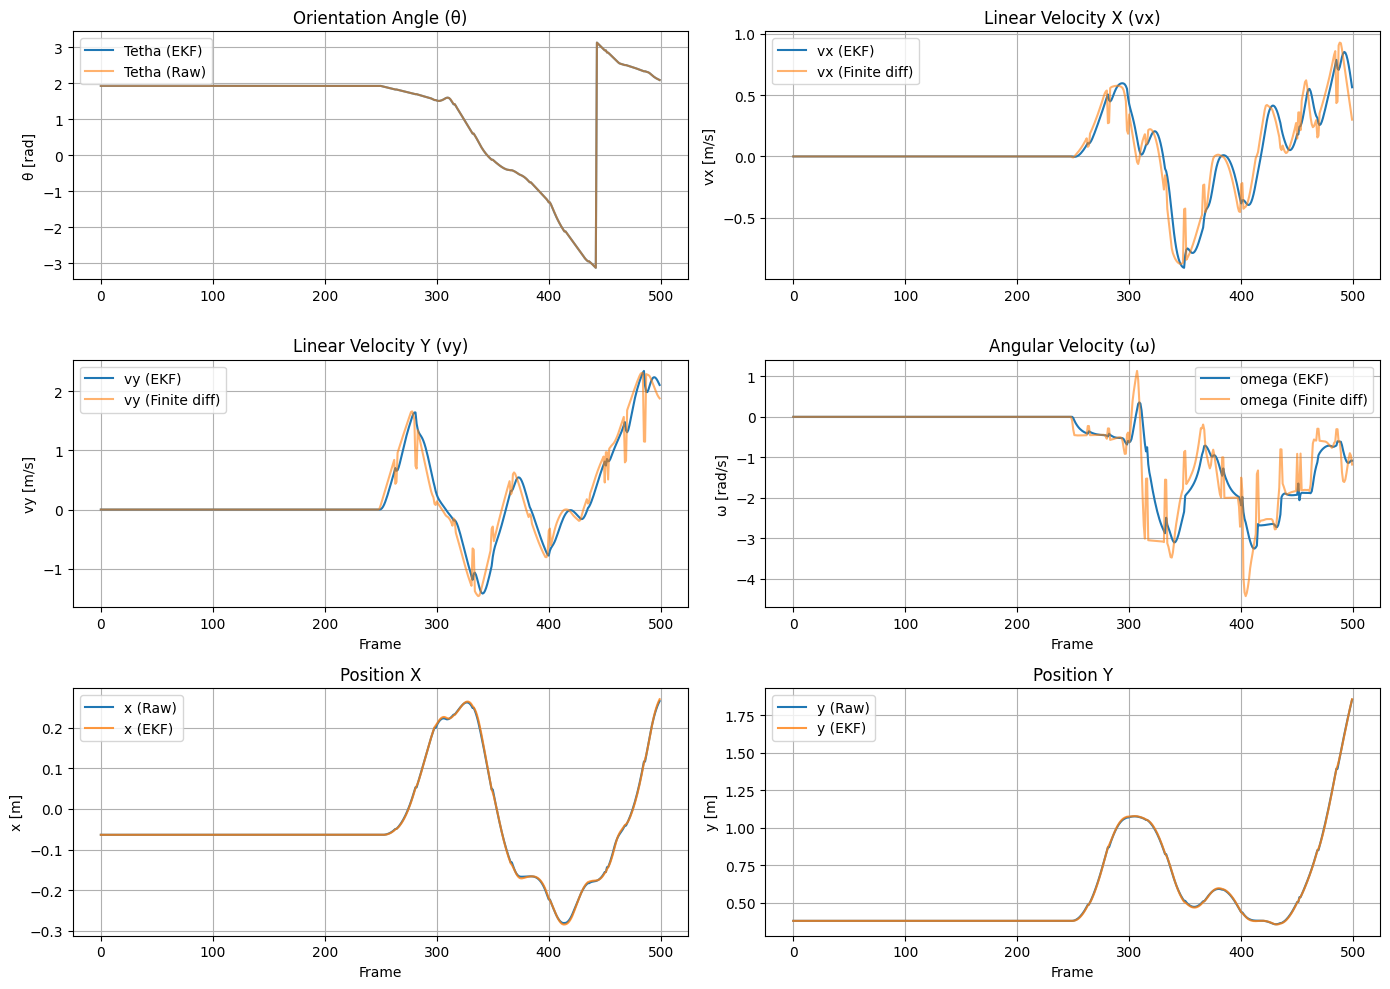

In [ ]:
# Número de muestras a graficar
N = 500

df = ekf_filter(df)
fig, axs = plt.subplots(3, 2, figsize=(14, 10))

# --- (0, 0) Orientation (θ)
axs[0, 0].plot(df['filtered_tetha'][:N], label='Tetha (EKF)')
axs[0, 0].plot(df['orientation'][:N], label='Tetha (Raw)', alpha=0.6)
axs[0, 0].set_title('Orientation Angle (θ)')
axs[0, 0].set_ylabel('θ [rad]')
axs[0, 0].grid(True)
axs[0, 0].legend()

# --- (0, 1) Velocity vx
axs[0, 1].plot(df['vx'][:N], label='vx (EKF)')
axs[0, 1].plot(compute_velocity(df['x'])[:N], label='vx (Finite diff)', alpha=0.6)
axs[0, 1].set_title('Linear Velocity X (vx)')
axs[0, 1].set_ylabel('vx [m/s]')
axs[0, 1].grid(True)
axs[0, 1].legend()

# --- (1, 0) Velocity vy
axs[1, 0].plot(df['vy'][:N], label='vy (EKF)')
axs[1, 0].plot(compute_velocity(df['y'])[:N], label='vy (Finite diff)', alpha=0.6)
axs[1, 0].set_title('Linear Velocity Y (vy)')
axs[1, 0].set_ylabel('vy [m/s]')
axs[1, 0].set_xlabel('Frame')
axs[1, 0].grid(True)
axs[1, 0].legend()

# --- (1, 1) Angular velocity ω
axs[1, 1].plot(df['omega'][:N], label='omega (EKF)')
axs[1, 1].plot(compute_angular_velocity(df['orientation'])[:N], label='omega (Finite diff)', alpha=0.6)
axs[1, 1].set_title('Angular Velocity (ω)')
axs[1, 1].set_ylabel('ω [rad/s]')
axs[1, 1].set_xlabel('Frame')
axs[1, 1].grid(True)
axs[1, 1].legend()

# --- (2, 0) Filtered vs Raw x position
axs[2, 0].plot(df['x'][:N], label='x (Raw)')
axs[2, 0].plot(est_x[:N], label='x (EKF)', alpha=0.8)
axs[2, 0].set_title('Position X')
axs[2, 0].set_ylabel('x [m]')
axs[2, 0].set_xlabel('Frame')
axs[2, 0].grid(True)
axs[2, 0].legend()

# --- (2, 1) Filtered vs Raw y position
axs[2, 1].plot(df['y'][:N], label='y (Raw)')
axs[2, 1].plot(est_y[:N], label='y (EKF)', alpha=0.8)
axs[2, 1].set_title('Position Y')
axs[2, 1].set_ylabel('y [m]')
axs[2, 1].set_xlabel('Frame')
axs[2, 1].grid(True)
axs[2, 1].legend()

# Organizar el layout
plt.tight_layout()
plt.show()

Afortunadamente el ruido es casi minimo. Sin embargo, se observa una notable diferencia en el calculo de velocidades con diferencias finitas vs el filtro.

## Velocidades comandadas vs Velocidades ejecutadas

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_robot_trajectory(df):
    """
    Grafica las trayectorias del robot (velocidades reales vs comandadas).
    Espera que el DataFrame contenga las siguientes columnas:
    - 'ElapsedTime'
    - 'vx', 'vy', 'omega' (opcional)
    - 'vx_command', 'vy_command', 'angular_command'

    Parámetros:
    - df: DataFrame filtrado por robot_filter
    """
    required_columns = [
        'ElapsedTime', 'vx_local', 'vy', 'vx_command', 'vy_command', 'angular_command'
    ]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Falta la columna requerida: '{col}'")

    #time = df['ElapsedTime']

    fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
    fig.suptitle("Trayectoria del robot: velocidades reales vs comandadas", fontsize=14)

    # Vx
    axs[0].plot(df['vx_local'], label='Vx real', linewidth=2)
    axs[0].plot(df['vx_command'], label='Vx comandado', linestyle='--')
    axs[0].set_ylabel("Velocidad X (m/s)")
    axs[0].legend()
    axs[0].grid(True)

    # Vy
    axs[1].plot(df['vy_local'], label='Vy real', linewidth=2)
    axs[1].plot(df['vy_command'], label='Vy comandado', linestyle='--')
    axs[1].set_ylabel("Velocidad Y (m/s)")
    axs[1].legend()
    axs[1].grid(True)

    # Omega (angular velocity)
    axs[2].plot(df['omega'], label='Ω real (estimada)', linewidth=2)
    axs[2].plot(df['angular_command'], label='Ω comandada', linestyle='--')
    axs[2].set_ylabel("Velocidad angular (rad/s)")
    axs[2].set_xlabel("Tiempo (s)")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
def transform_local_to_global(vx_cmd, vy_cmd, theta):
    """
    Transforma las velocidades locales a coordenadas globales usando la orientación del robot.

    Parámetros:
        vx_cmd (array-like): velocidad comandada en eje x (local)
        vy_cmd (array-like): velocidad comandada en eje y (local)
        theta (array-like): orientación del robot en radianes

    Devuelve:
        vx_global, vy_global: velocidades transformadas al sistema global
    """
    vx_cmd = np.asarray(vx_cmd)
    vy_cmd = np.asarray(vy_cmd)
    theta = np.asarray(theta)

    vx_global = np.cos(-theta) * vx_cmd - np.sin(-theta) * vy_cmd
    vy_global = np.sin(-theta) * vx_cmd + np.cos(-theta) * vy_cmd

    return vx_global, vy_global

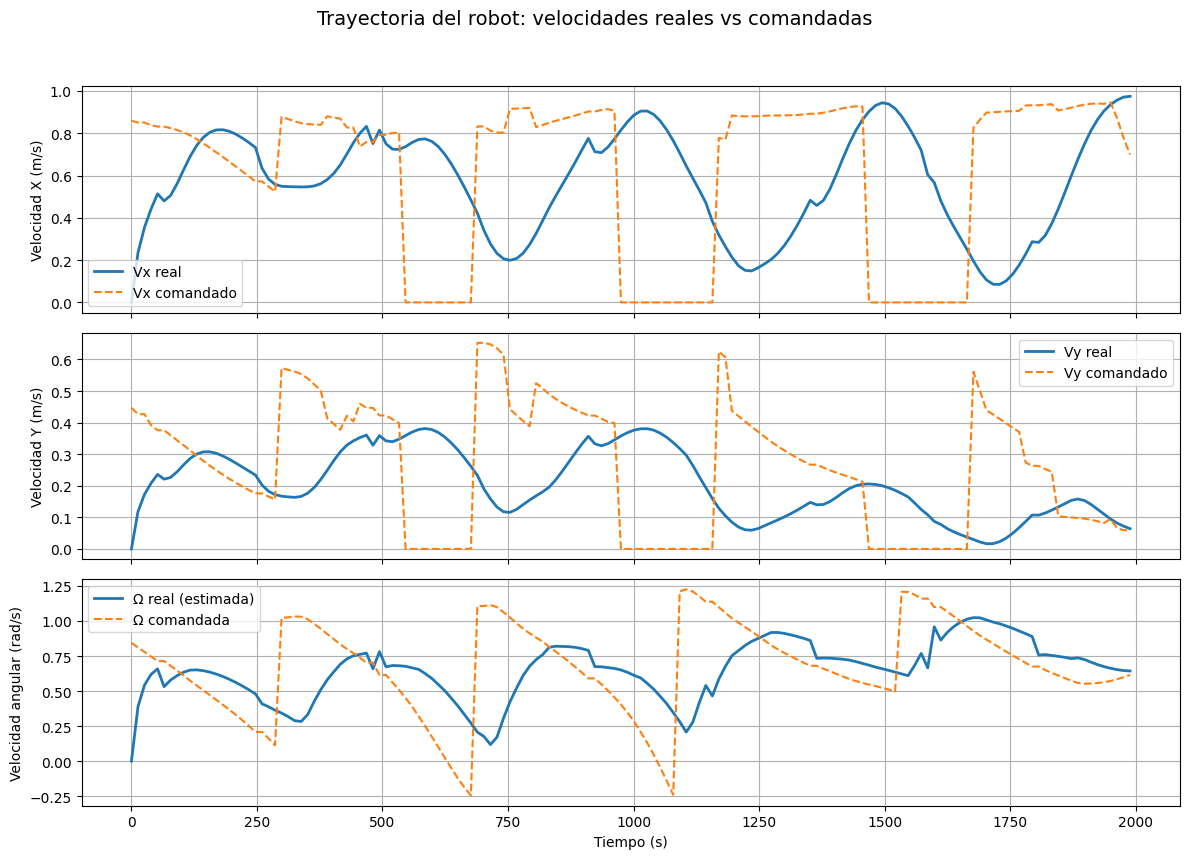

In [ ]:
plot_df = pd.read_csv("test_data0.csv")[:2000]
plot_df = robot_filter(0, 0, plot_df)

plot_df = ekf_filter(plot_df)
plot_df['vx_local'], plot_df['vy_local'] = transform_local_to_global(
    plot_df['vx'], plot_df['vy'], plot_df['filtered_tetha']
)
plot_robot_trajectory(plot_df)

Se observan las velocidades comandadas y las velocidades reales que tienen cierto desfase, esto se puede explicar debido a las dinamicas del robot, ya que no puede alcanzar una velocidad instantaneamente sino que tiene que acelerar para alcanzarla.

# Fully Connected Neural Network

# Physics model

In [ ]:
import torch
import torch.nn as nn

class CinematicPhysicsModel(nn.Module):
    def __init__(self, alpha=1.0, dt=0.016):
        super().__init__()
        self.alpha = alpha  # Acceleration gain
        self.dt = dt        # Time step (seconds)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, 7)
           [vx, vy, omega, orientation, vx_cmd, vy_cmd, angular_cmd]
        Returns:
           predicted next [vx, vy, omega] in global frame
        """
        vx, vy, omega = x[:, 0], x[:, 1], x[:, 2]
        theta = x[:, 3]  # orientation in radians
        vx_cmd, vy_cmd, omega_cmd = x[:, 4], x[:, 5], x[:, 6]

        # --- Convert global velocity to local ---
        vx_local = torch.cos(theta) * vx + torch.sin(theta) * vy
        vy_local = -torch.sin(theta) * vx + torch.cos(theta) * vy

        # --- Compute acceleration and update in local frame ---
        ax = self.alpha * (vx_cmd - vx_local)
        ay = self.alpha * (vy_cmd - vy_local)
        a_omega = self.alpha * (omega_cmd - omega)

        vx_local_next = vx_local + ax * self.dt
        vy_local_next = vy_local + ay * self.dt
        omega_next = omega + a_omega * self.dt

        # --- Convert updated local velocity back to global frame ---
        vx_next = torch.cos(theta) * vx_local_next - torch.sin(theta) * vy_local_next
        vy_next = torch.sin(theta) * vx_local_next + torch.cos(theta) * vy_local_next

        return torch.stack([vx_next, vy_next, omega_next], dim=1)

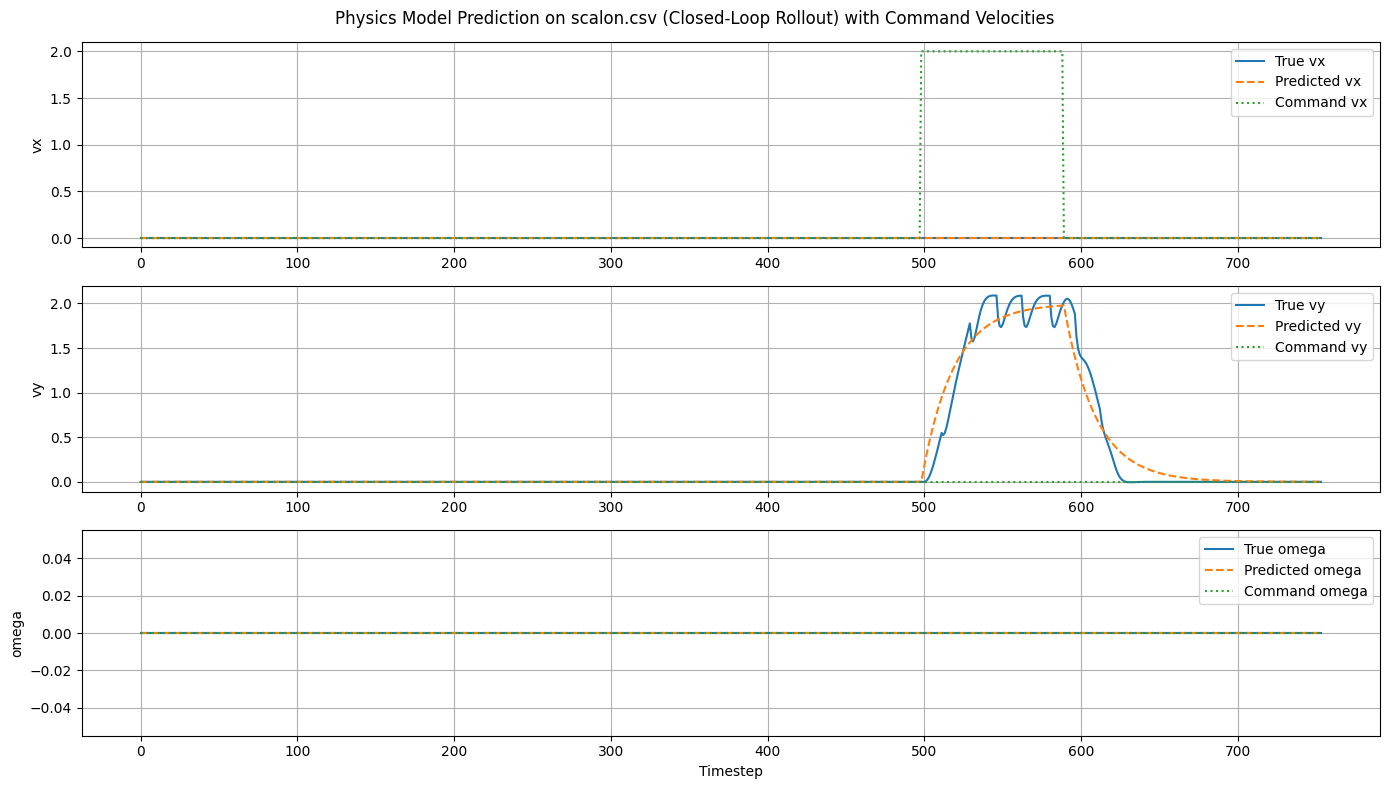

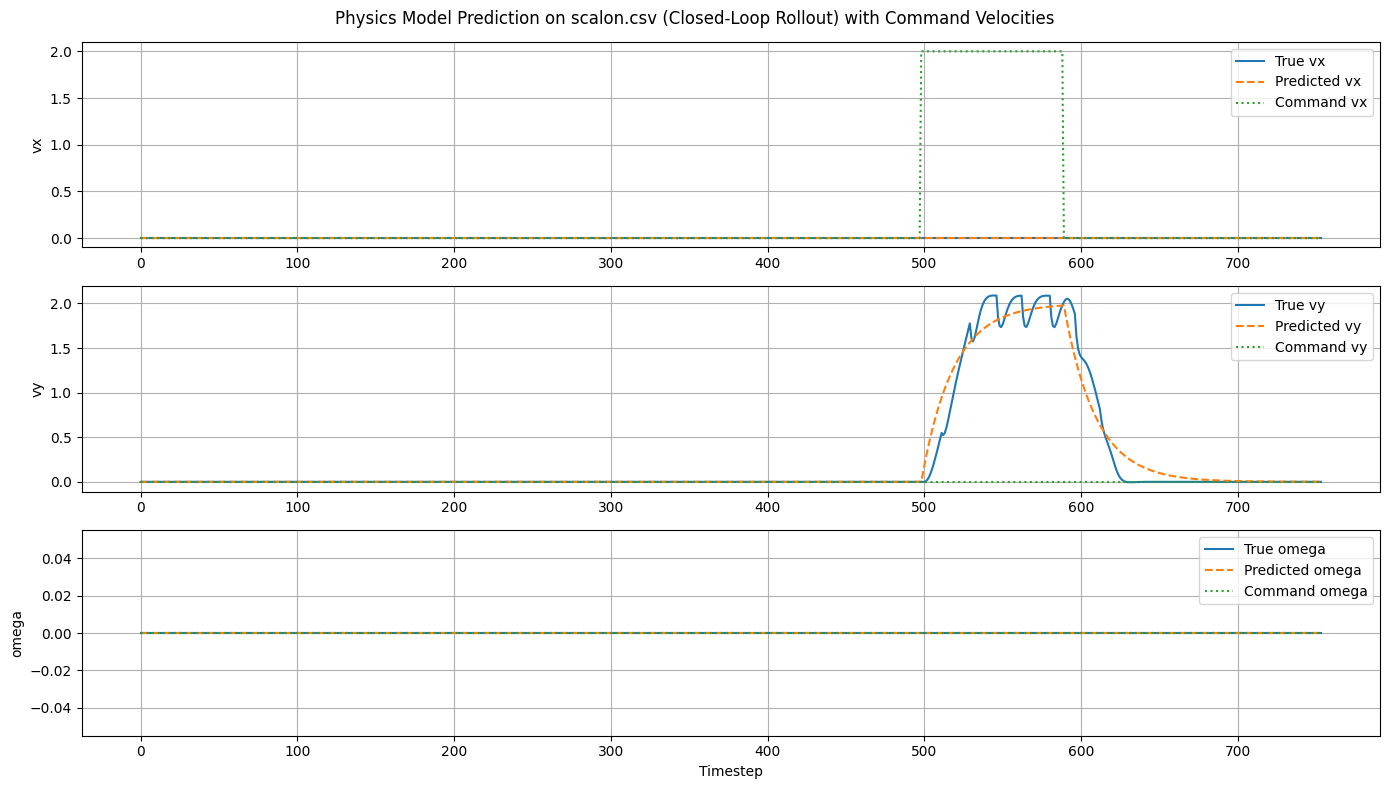

In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

# === 1. Load CSV ===
df = pd.read_csv("scalon.csv")
df = robot_filter(0,0,df)
df = ekf_filter(df)

# Make sure the columns match the model's expectations
INPUT_COLS = ['vx', 'vy', 'omega', 'filtered_tetha', 'vx_command', 'vy_command', 'angular_command']

assert all(col in df.columns for col in INPUT_COLS), "Missing required columns in scalon.csv"

# Convert to torch tensor
data = torch.tensor(df[INPUT_COLS].values, dtype=torch.float32)

model = CinematicPhysicsModel(alpha=3.0, dt=0.016)
model.eval()

# === 3. Simulate using predicted velocity as next input ===
predictions = []

# Start from the first row
state = data[0].clone()

for t in range(len(data) - 1):
    input_tensor = state.unsqueeze(0)  # Shape (1, 7)
    with torch.no_grad():
        output = model(input_tensor).squeeze(0)  # (vx_next, vy_next, omega_next)

    # Keep command and orientation from dataset
    next_theta = data[t + 1, 3]
    next_cmds = data[t + 1, 4:7]

    # Build next state: use predicted velocity, but keep command + orientation from dataset
    state = torch.cat([output, next_theta.unsqueeze(0), next_cmds])
    predictions.append(output.numpy())

# Convert to array
import numpy as np
predictions = np.array(predictions)

# === 4. Plot ===
labels = ['vx', 'vy', 'omega']
cmd_labels = ['vx_command', 'vy_command', 'angular_command']

plt.figure(figsize=(14, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)

    # True output
    plt.plot(df[labels[i]].values[1:], label=f"True {labels[i]}")

    # Predicted output
    plt.plot(predictions[:, i], '--', label=f"Predicted {labels[i]}")

    # Command (same timestep as predictions)
    plt.plot(df[cmd_labels[i]].values[1:], ':', label=f"Command {labels[i]}")

    plt.ylabel(labels[i])
    plt.grid(True)
    plt.legend()

plt.xlabel("Timestep")
plt.suptitle("Physics Model Prediction on scalon.csv (Closed-Loop Rollout) with Command Velocities")
plt.tight_layout()
plt.show()
